In [73]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import save_model #, load_model
from tensorflow.python.client import device_lib
import keras
from keras.models import load_model
from keras import backend as K
import pandas as pd

In [15]:
print(f"tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

tensorflow version: 1.11.0
Keras version: 2.2.4


In [16]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # DISABLE GPU

In [17]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12595637699729119572
]


In [18]:
K.tensorflow_backend._get_available_gpus()

[]

In [ ]:
num_cores = 12

CPU, GPU = 1, 0

if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU}) #, 'GPU' : num_GPU})
sess = tf.Session(config=config)
K.set_session(sess)

## Загрузка

In [19]:
def visualize(data):
    plt.imshow(data, cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [20]:
mnist = tf.keras.datasets.mnist

In [21]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [22]:
x_train.shape

(60000, 28, 28)

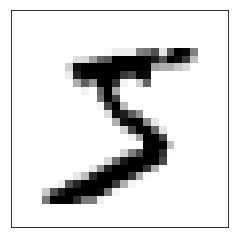

In [23]:
visualize(x_train[0])

In [24]:
# scaling between 0 and 1
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

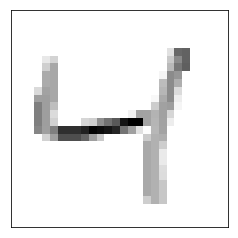

In [25]:
visualize(x_train[2])

## Model Train and Save

In [81]:
#with tf.device('/GPU:1'):
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(784, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
%timeit -n1 -r1 model.fit(x_train, y_train, epochs=8, batch_size=64)

Epoch 1/8
60000/60000 [==============================] - 8s 137us/step - loss: 0.2136 - acc: 0.9358
Epoch 2/8
60000/60000 [==============================] - 7s 123us/step - loss: 0.0804 - acc: 0.9752
Epoch 3/8
60000/60000 [==============================] - 7s 123us/step - loss: 0.0498 - acc: 0.9842
Epoch 4/8
60000/60000 [==============================] - 8s 126us/step - loss: 0.0355 - acc: 0.9881
Epoch 5/8
60000/60000 [==============================] - 8s 134us/step - loss: 0.0274 - acc: 0.9908
Epoch 6/8
60000/60000 [==============================] - 8s 128us/step - loss: 0.0189 - acc: 0.9938
Epoch 7/8
60000/60000 [==============================] - 8s 132us/step - loss: 0.0186 - acc: 0.9934
Epoch 8/8
60000/60000 [==============================] - 8s 126us/step - loss: 0.0166 - acc: 0.9945
1min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [82]:
%timeit -n1 -r1 val_loss, val_acc = model.evaluate(x_test, y_test, batch_size=784)
print(f"Validation loss={val_loss}\nValidation accuracy={val_acc}")

10000/10000 [==============================] - 0s 19us/step
188 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Validation loss=0.09522475127279759
Validation accuracy=0.9727999946594238


In [ ]:
# saving
save_model(model, 'mnist_model.hdf5', overwrite=False)

## Model Load

In [28]:
# loading
model_file = 'mnist_model.hdf5'
#model2 = tf.keras.models.load_model(model_file)
model = load_model(model_file)

In [83]:
val_loss, val_acc = model.evaluate(x_test, y_test, batch_size=784)
print(f"Validation loss={val_loss:.02%}\nValidation accuracy={val_acc:.02%}")

10000/10000 [==============================] - 0s 13us/step
Validation loss=8.91%
Validation accuracy=97.91%


## Model use

In [84]:
# первые N значений картинок из тестовой выборки
N = 10
y_test[:N]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

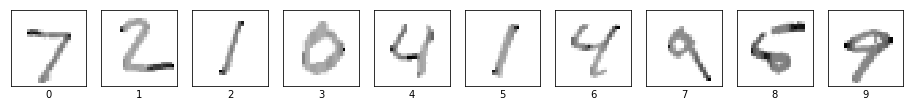

In [85]:
# визуализация первых N картинок из тестовой выборки
plt.rcParams['figure.figsize'] = [16, 2]
fig, ax = plt.subplots(nrows=1, ncols=N)
for x in range(N):
    ax[x].imshow(x_test[x], cmap=plt.cm.binary)
    ax[x].set_xticks([])
    ax[x].set_yticks([])
    ax[x].set_xlabel(str(x))
plt.show()

In [86]:
# классификация картинок
predictions = model.predict_classes(x_test)

## Анализ результатов

In [87]:
# датафрейм с исходными значениями тестовой выборки и предсказанными моделью
df = pd.DataFrame(list(zip(y_test, predictions)), columns=['actual', 'predicted'])

In [88]:
# выводим ошибки предсказаний
df_errors = df[df.actual != df.predicted]
df_errors.head()

,actual,predicted
62,9,8
247,4,2
259,6,0
308,4,8
321,2,7


In [89]:
df_errors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 62 to 9982
Data columns (total 2 columns):
actual       209 non-null int64
predicted    209 non-null int64
dtypes: int64(2)
memory usage: 4.9 KB
